<p style="text-align:center;font-size:40px;font-weight:bold;color:#02bd9b">CRAFTY</p>
<p style="text-align:center;font-size:35px;font-weight:bold;color:#fea83a">Simone Passèra</p>


<p style="text-align:center;font-size:25px;font-weight:bold;color:#2b96de">Analisi generali dei dati della blockchain</p>


<h2 style="color:#00c4c4">DataSet</h2>


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
import requests
from bs4 import BeautifulSoup

# Creo un dataframe per ogni file relativo alla blockchain Bitcoin
inputs = pd.read_csv("inputs.csv", names=["txId", "prevTxId", "prevTxPos"])
outputs = pd.read_csv(
    "outputs.csv",
    names=["txId", "position", "addressId", "amount", "scripttype"],
)
mapping = pd.read_csv("mappings.csv", names=["hash", "addressId"])
transactions = pd.read_csv(
    "transactions.csv",
    names=["timestamp", "blockId", "txId", "isCoinbase", "fee"],
)

# Converto il timestamp in formato unix (secondi), nell' oggetto pandas datetime
transactions["timestamp"] = pd.to_datetime(transactions["timestamp"], unit="s")

<h2 style="color:#fe5f5e">Analisi n.1</h2>

- Distribuzione del numero di transazioni per blocco (occupazione del blocco), nell’intero
  periodo temporale considerato


In [2]:
# Raggruppo le transazioni per il timestamp, e conto il numero di transazioni,
# contenute nel blocco minato in quella data
analisi_1 = (
    transactions.groupby("timestamp")["timestamp"]
    .count()
    .reset_index(name="transactions")
)

# Imposto il tema di default di Seaborn
sns.set_theme()

<Axes: xlabel='timestamp', ylabel='Transazioni per blocco'>

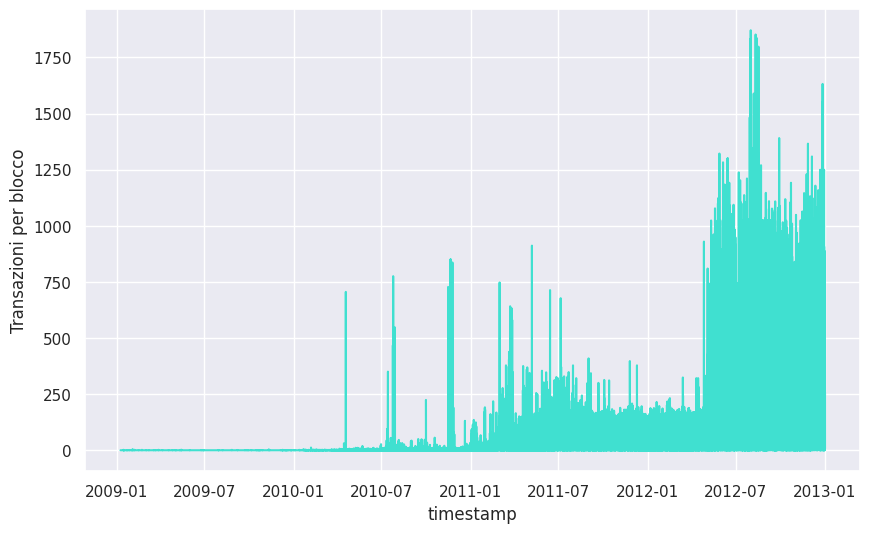

In [3]:
# Plot delle transazioni per blocco per ogni timestamp
plt.figure(figsize=(10, 6))
plt.ylabel("Transazioni per blocco")
sns.lineplot(data=analisi_1, x="timestamp", y="transactions", color="turquoise")

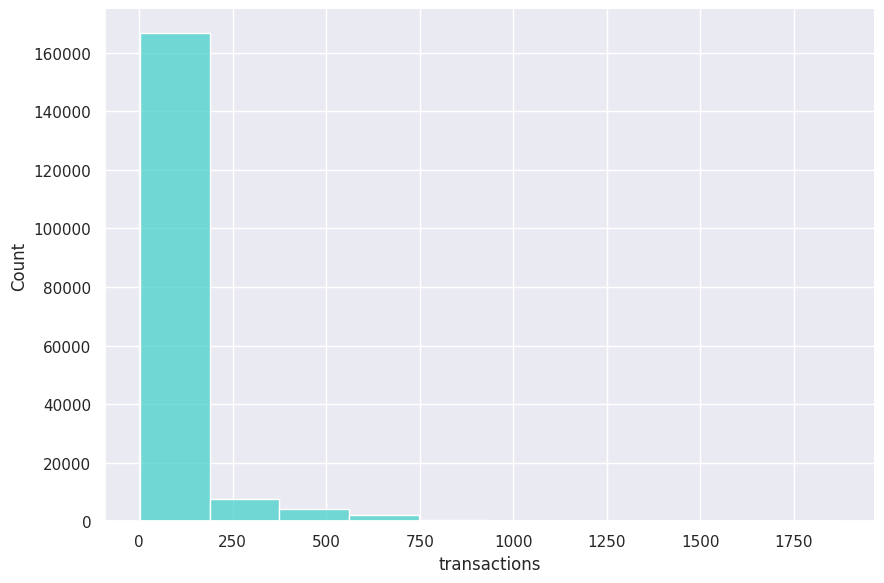

In [4]:
# Plot della distribuzione delle transazioni all'interno di un blocco
sns.displot(
    analisi_1["transactions"], bins=10, color="mediumturquoise", height=6, aspect=1.5
)

<h2 style="color:#fe5f5e">Analisi n.2</h2>

- Evoluzione dell'occupazione dei blocchi nel tempo, considerando intervalli temporali di due
  mesi. In questo caso produrre un grafico che riporti il numero di transazioni medie per ogni
  periodo considerato


/tmp/ipykernel_7342/4067697057.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  analisi_1.groupby(pd.Grouper(key="timestamp", freq="2M")).mean().reset_index()


<Axes: xlabel='timestamp', ylabel='Transazioni per blocco'>

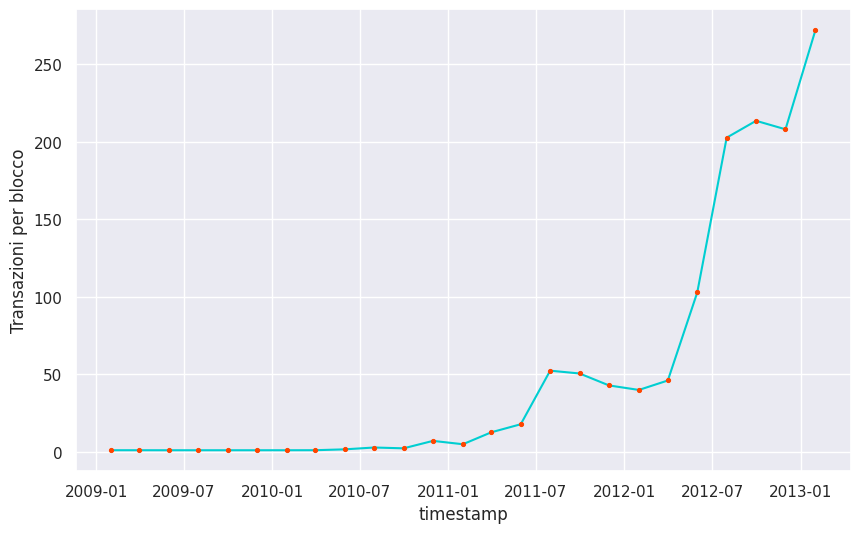

In [5]:
# Raggruppo i timestamp precedenti per intervalli di due mesi ed applico la media ad ogni gruppo
analisi_2 = (
    analisi_1.groupby(pd.Grouper(key="timestamp", freq="2M")).mean().reset_index()
)

# Plot del numero medio di transazioni all'interno dei blocchi, per ogni due mesi
plt.figure(figsize=(10, 6))
plt.ylabel("Transazioni per blocco")
sns.lineplot(
    data=analisi_2,
    x="timestamp",
    y="transactions",
    color="darkturquoise",
    marker="o",
    markersize=3,
    markeredgecolor="orangered",
    markerfacecolor="orangered",
)

<h2 style="color:#fe5f5e">Analisi n.3</h2>

- Ammontare totale degli **UTXO** al momento dell’ultima transazione registrata nella
  blockchain considerata


In [6]:
# Left join tra la tabella degli output e quella degli input
UTXO = pd.merge(
    outputs,
    inputs,
    how="left",
    left_on=["txId", "position"],
    right_on=["prevTxId", "prevTxPos"],
    indicator=True,
)

# Seleziono gli output che non appaiono in nessuna transazione come input
UTXO = UTXO.loc[UTXO["_merge"] == "left_only", "amount"]
print(f"Somma totale UTXO = {UTXO.sum()} BTC")

Somma totale UTXO = 859303372614879 BTC


<h2 style="color:#fe5f5e">Analisi n.4</h2>

- Distribuzione degli intervalli di tempo che intercorrono tra la transazione che genera un
  valore in output (**UTXO**) e quella che lo consuma, per gli output spesi nel periodo
  considerato


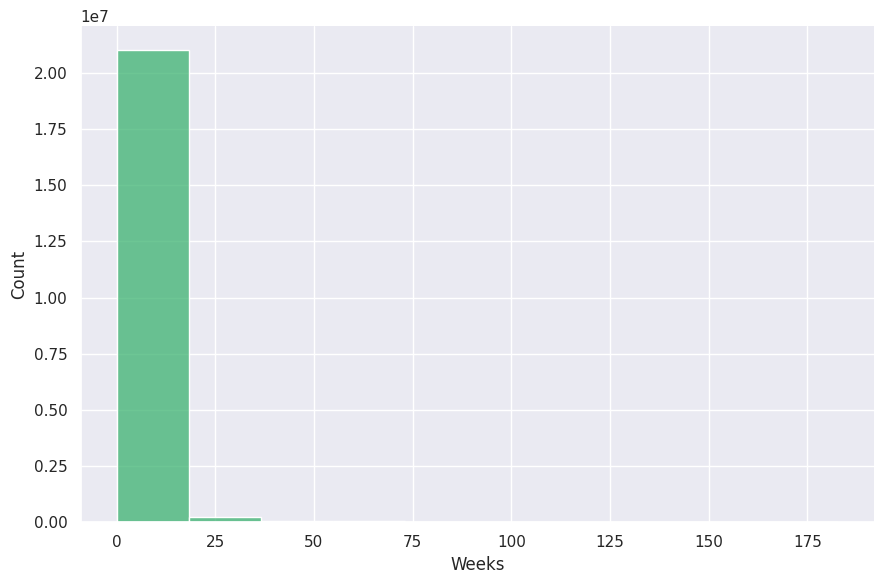

In [7]:
# Inner join tra la tabella degli output e quella degli input
tx_match = pd.merge(
    outputs, inputs, left_on=["txId", "position"], right_on=["prevTxId", "prevTxPos"]
)
tx_match = tx_match.loc[:, ["txId_x", "txId_y"]]
tx_match.rename(columns={"txId_x": "txId_out", "txId_y": "txId_in"}, inplace=True)

# Inner join tra 'tx_match' e la tabella delle transazioni, per recuperare il timestamp delle transazioni in output
tx_out_time = pd.merge(tx_match, transactions, left_on="txId_out", right_on="txId")
tx_out_time.rename(columns={"timestamp": "time_out"}, inplace=True)
tx_out_time = tx_out_time.loc[:, ["time_out", "txId_in"]]

# Inner join tra 'tx_out_time' e la tabella delle transazioni, per recuperare il timestamp delle transazioni in input
tx_in_time = pd.merge(tx_out_time, transactions, left_on="txId_in", right_on="txId")
tx_in_time.rename(columns={"timestamp": "time_in"}, inplace=True)

# Seleziono i due timestamp che si riferiscono, al tempo in cui un output è stato generato (time_out) e quando è stato speso (time_in)
tx_time = tx_in_time.loc[:, ["time_out", "time_in"]]

# Calcolo la differenza tra le due date, in numero di settimane
tx_time["Weeks"] = (tx_time["time_in"] - tx_time["time_out"]) / np.timedelta64(1, "W")

# Plot della distribuzione degli intervalli
sns.displot(tx_time["Weeks"], bins=10, color="mediumseagreen", height=6, aspect=1.5)

<h2 style="color:#fe5f5e">Analisi n.5</h2>

- Distribuzione media delle fee per ogni blocco nel periodo considerato.


In [8]:
# Raggruppo le transazioni per ogni blocco e la data in cui il blocco è stato minato
# Calcolo la media delle fee per ogni blocco
fee = (
    transactions.groupby(["blockId", "timestamp"])["fee"]
    .mean()
    .reset_index(name="fee_mean")
)

<Axes: xlabel='timestamp', ylabel='Fee'>

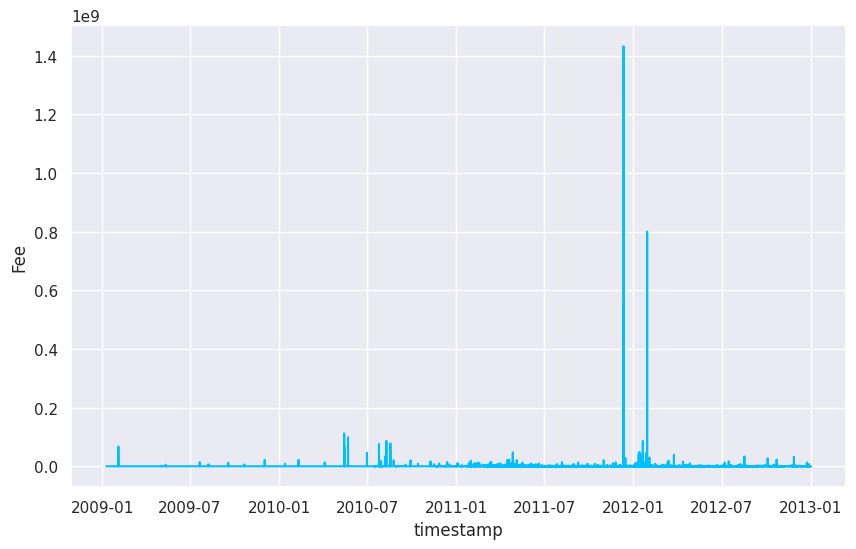

In [9]:
# Plot delle fee medie per blocco per ogni timestamp
plt.figure(figsize=(10, 6))
plt.ylabel("Fee")
sns.lineplot(data=fee, x="timestamp", y="fee_mean", color="deepskyblue")

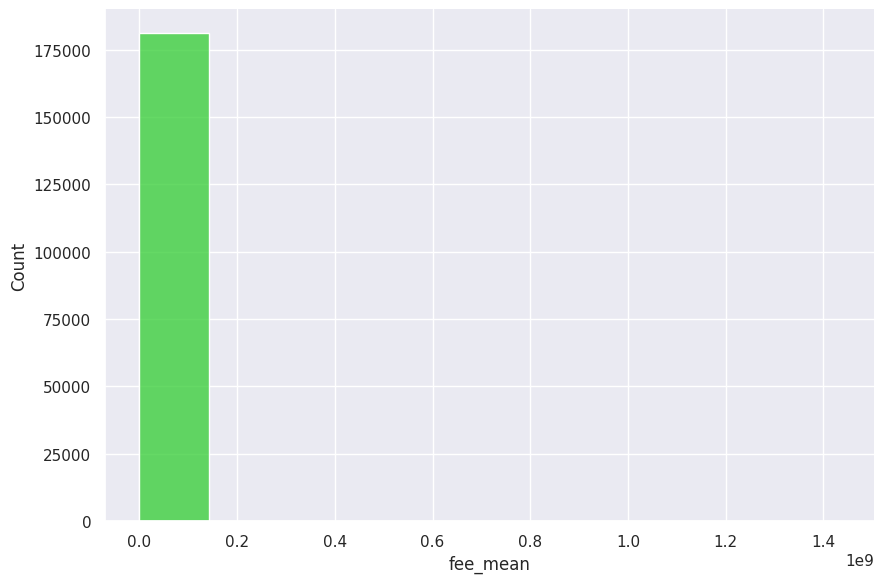

In [10]:
# Plot della distribuzione media delle fee per ogni blocco
sns.displot(fee["fee_mean"], bins=10, color="limegreen", height=6, aspect=1.5)

<p style="text-align:center;font-size:25px;font-weight:bold;color:#2b96de">Clusterizzazione degli indirizzi di Bitcoin: euristica multi-input</p>


In [11]:
# Inner join tra la tabella degli input, le transazioni e la tabella degli output, per legare
# ogni input all'output precedente a cui fa riferimento
in_tx = pd.merge(inputs, transactions, on="txId")
in_tx_out = pd.merge(
    in_tx, outputs, left_on=["prevTxId", "prevTxPos"], right_on=["txId", "position"]
)

# Raggruppo per ogni transazione la lista degli input che ne fanno parte. L'insieme degli indirizzi
# in ogni gruppo, appartengono ad un utente per l'euristica multi-input
addresses_groups = in_tx_out.groupby("txId_x")["addressId"]

# Inizializzo un grafo non orientato
G = nx.Graph()

# Per ogni gruppo di indirizzi, si aggiunge ogni indirizzo nel grafo come un nodo
# e si aggiunge un arco tra il primo indirizzo ed ogni altro indirizzo di input appartenente alla stessa transazione
for _, addresses in addresses_groups:
    addr_list = list(set(addresses.tolist()))
    first_addr = addr_list[0]

    if len(addr_list) > 1:
        for i in range(1, len(addr_list)):
            G.add_edge(first_addr, addr_list[i])
    else:
        G.add_node(first_addr)

<h2 style="color:#fe5f5e">Analisi n.1</h2>

- Dimensione media, minima e massima dei cluster
- Numero dei cluster


In [12]:
# Ogni cluster di indirizzi, in altre parole una componente connessa del grafo, appartiene ad un utente in Bitcoin
clusters = nx.connected_components(G)

# Statistiche sulla dimensione dei cluster
dimensions = [len(c) for c in clusters]

print(f"Dimensione media dei cluster = {round(np.mean(dimensions), 2)} indirizzi")
print(f"Dimensione minima dei cluster = {min(dimensions)} indirizzo")
print(f"Dimensione massima dei cluster = {max(dimensions)} indirizzi")
print(f"Numero dei cluster = {nx.number_connected_components(G)}")

Dimensione media dei cluster = 1.98 indirizzi
Dimensione minima dei cluster = 1 indirizzo
Dimensione massima dei cluster = 259773 indirizzi
Numero dei cluster = 4001940


<h2 style="color:#fe5f5e">Analisi n.2</h2>

- Distribuzione delle dimensioni dei cluster


Text(0.5, 12.444444444444452, 'Size')

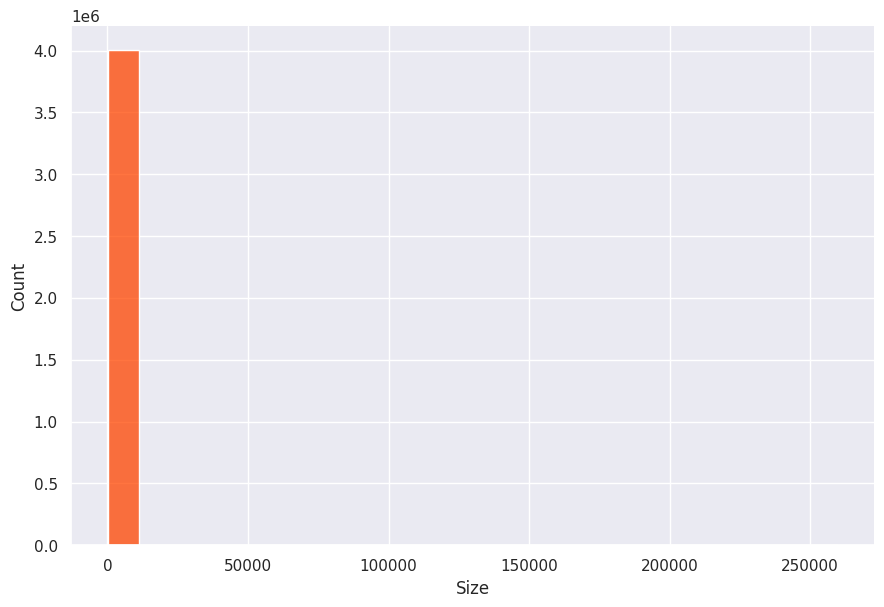

In [13]:
# Plot della distribuzione delle dimensioni dei cluster
sns.displot(dimensions, color="orangered", height=6, aspect=1.5)
plt.xlabel("Size")

<p style="text-align:center;font-size:25px;font-weight:bold;color:#2b96de">Deanonimizzazione degli indirizzi</p>


Per deanonimizzare i dieci cluster di dimensione maggiore, si considerano i seguenti siti web: walletexplorer.com e bitinfocharts.com . Ogni cluster contiene un numero elevato di indirizzi, quindi per deanonimizzarli si esegue lo scraping su un numero limitato (10) di indirizzi casuali per ogni cluster. Un cluster si considera deanonimizzato se un indirizzo al suo interno è presente in entrambi i siti web, questo per limitare il numero di richieste da sottomettere, in modo da evitare rallentamenti a causa di sistemi anti-scraping. Inoltre per l'euristica multi-input la deanonimizzazione di un solo indirizzo nel cluster è sufficiente per associare a tutti gli indirizzi la stessa entità.


In [14]:
# Seleziono i dieci cluster di dimensione maggiore
clusters = nx.connected_components(G)
top_clusters = (sorted(clusters, key=len, reverse=True))[:10]

# Converto ogni indirizzo logico nel corrispettivo hash reale
top_clusters_hash = list()

for i in range(len(top_clusters)):
    addresses_series = pd.Series(data=list(top_clusters[i]), name="addressId")
    top_clusters_hash.append(pd.merge(addresses_series, mapping, on="addressId"))

# Url dei siti web con cui provare a deadonimizzare gli hash
walletexplorer_url = "https://www.walletexplorer.com"
base_bitinfocharts_url = "https://bitinfocharts.com/bitcoin/address/"
headers = {
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36"
}

# Deanonimizzo i dieci cluster
for i in range(len(top_clusters_hash)):
    addresses = top_clusters_hash[i]["hash"]

    # Risultati
    walletexplorer_result = ""
    bitinfocharts_result = ""

    # Considero un hash deanonimizzato se ottengo un risultato da entrambi i siti web
    # Eseguo al massimo dieci tentativi per ogni cluster su hash random
    hit = False

    for j in range(10):
        address = addresses.iloc[np.random.randint(addresses.size)]
        walletexplorer_html = requests.get(
            walletexplorer_url, params={"q": address}, headers=headers
        )
        walletexplorer_html.raise_for_status()
        walletexplorer_soup = BeautifulSoup(walletexplorer_html.content, "html.parser")

        if walletexplorer_soup.find("p", class_="error") == None:
            walletexplorer_result = walletexplorer_soup.title.text

            bitinfocharts_url = base_bitinfocharts_url + str(address)
            bitinfocharts_html = requests.get(bitinfocharts_url, headers=headers)
            bitinfocharts_html.raise_for_status()
            bitinfocharts_soup = BeautifulSoup(
                bitinfocharts_html.content, "html.parser"
            )

            a = bitinfocharts_soup.find("a", attrs={"style": "color: #018174"})

            if a != None:
                bitinfocharts_result = (
                    a.text.removeprefix("wallet: ") + " [BitInfoCharts.com]"
                )
                hit = True
                break

    # Stampo i risultati
    if hit:
        print(f"Cluster n.{i + 1} : size=[{addresses.size}] address_hit=[{address}]")
        print(f"Wallet -> {walletexplorer_result} | {bitinfocharts_result}\n")
    else:
        print(f"Cluster n.{i + 1} : size=[{addresses.size}]")
        print(f"Wallet -> ?\n")

Cluster n.1 : size=[259773] address_hit=[17YVTz4z47kxMCdf6WNz4zukNaUmgaMRTd]
Wallet -> CoinJoinMess [WalletExplorer.com] | F2Pool [BitInfoCharts.com]

Cluster n.2 : size=[121464] address_hit=[1JXiivZ2KugVA3Bur7t3aiibk2MWVESXrr]
Wallet -> SilkRoadMarketplace [WalletExplorer.com] | SilkRoadMarketplace [BitInfoCharts.com]

Cluster n.3 : size=[99645] address_hit=[1BbWREWoikyTkETwGK7zvohG2PetEcPH4r]
Wallet -> 00005795a77580a4 [WalletExplorer.com] | 65086 [BitInfoCharts.com]

Cluster n.4 : size=[76923] address_hit=[1ELdkioanAJ4sH3Cn9mRXki3d1qdG7dpuo]
Wallet -> Instawallet.org [WalletExplorer.com] | Instawallet.org [BitInfoCharts.com]

Cluster n.5 : size=[40969] address_hit=[16sgKDA6S9sdgxhZSxhm4Wf34pd2Fd7G2a]
Wallet -> 00003ee5f7d2cd2a [WalletExplorer.com] | 276627 [BitInfoCharts.com]

Cluster n.6 : size=[30916] address_hit=[11h8gVMmhhxJHndKF1vsHGe9VNiDdyYZu]
Wallet -> BTC-e.com-old [WalletExplorer.com] | Eligius [BitInfoCharts.com]

Cluster n.7 : size=[26615] address_hit=[1riqUTS4vYTH5rFTce

<h2 style="color:#fe5f5e">Risultati ottenuti</h2>

I servizi deanonimizzati sono:

- F2Pool -> Una mining pool
- SilkRoadMarketplace -> Un e-commerce ormai chiuso presente sulla rete Tor utilizzato per il commercio illegale
- Instawallet.org -> Era un servizio di gestione dei wallet online
- BTC-e.com -> Era un exchange di bitcoin
- Eligius -> Una mining pool
- BtcDice.com -> Un servizio legato al gioco d'azzardo

Alcuni cluster non sono stati deanonimizzati perchè appartengono a wallet sconosciuti, oppure perchè i due siti web restituiscono risultati diversi, forse a causa di informazioni errate contenute all'interno dei database online.
